In [1]:
import sys
import math
import itertools
from pathlib import Path
from datetime import datetime
from typing import Callable, Tuple

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 1. Add parent directory to path
sys.path.append(str(Path("..").resolve()))

from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# 2. Import modularized code
from model import ConditionalRBM, train_loop, get_sigmoid_curve, save_model

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data resides in: {data_dir.resolve()}")

Running on: cpu
Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_16_mod/measurements


In [2]:
def generate_all_states(num_qubits: int, device: torch.device):
    """Generates all 2^N basis states."""
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    if not gt_path.exists(): return 0.0
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    # Uses the method from the imported ConditionalRBM class
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [3]:
# --- EXPERIMENT CONFIG ---
SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000
FILE_SUFFIX = "20000"

# Exact values from your 1D Chain Data
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]
h_novel   = [0.60, 0.70, 1.30, 1.40]

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Construct paths (1D Chain)
file_paths = []
print("Loading Training Data (1D Chain L=16)...")
for h in h_support:
    fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_{FILE_SUFFIX}.npz"
    fpath = data_dir / fname
    if fpath.exists():
        file_paths.append(fpath)
    else:
        print(f"  ! MISSING: {fname}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLES] * len(file_paths))
print(f"Dataset loaded. Shape: {ds.values.shape}")

Loading Training Data (1D Chain L=16)...
Dataset loaded. Shape: torch.Size([140000, 16])


In [4]:
# --- Hyperparameters ---
# Preserving the specific settings from your notebook cell
HIDDEN_UNITS = 64
COND_WIDTH = 64
CD_K = 20
LR_INIT = 1e-2
LR_FINAL = 1e-4
N_EPOCHS = 50
BATCH_SIZE = 1024
NOISE_FRAC = 0.1

loader = MeasurementLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

# Initialize Model (From Module)
model = ConditionalRBM(
    num_visible=SYSTEM_SIZE,
    num_hidden=HIDDEN_UNITS,
    cond_dim=1,
    conditioner_width=COND_WIDTH,
    k=CD_K,
    T=1.0
).to(device)

# Note: Your notebook Cell 2 defined initialize_weights(std=0.01)
# The module defaults to std=0.01 in __init__, so we do not need to call it again.
# This ensures RNG state consistency.

optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)
schedule_steps = N_EPOCHS * len(loader)
scheduler = get_sigmoid_curve(LR_INIT, LR_FINAL, schedule_steps, falloff=0.002)

print(f"Training Symmetric (Augmented) CRBM on L={SYSTEM_SIZE}...")
model = train_loop(
    model=model,
    optimizer=optimizer,
    loader=loader,
    num_epochs=N_EPOCHS,
    lr_schedule_fn=scheduler,
    noise_frac=NOISE_FRAC,
    rng=rng
)
print("Training Complete.")

Training Symmetric (Augmented) CRBM on L=16...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0209     | 0.009986
10     | +0.0014     | 0.009840
20     | +0.0059     | 0.007997
30     | -0.0019     | 0.002109
40     | -0.0031     | 0.000260
50     | -0.0151     | 0.000110
Training Complete.


Generating full Hilbert space for exact evaluation...
h      | Type       | Overlap   
-----------------------------------
0.50   | Support    | 0.99965
0.60   | Novel      | 0.99939
0.70   | Novel      | 0.99907
0.80   | Support    | 0.99872
0.95   | Support    | 0.99779
1.00   | Support    | 0.99722
1.05   | Support    | 0.99698
1.20   | Support    | 0.99825
1.30   | Novel      | 0.99828
1.40   | Novel      | 0.99834
1.50   | Support    | 0.99845


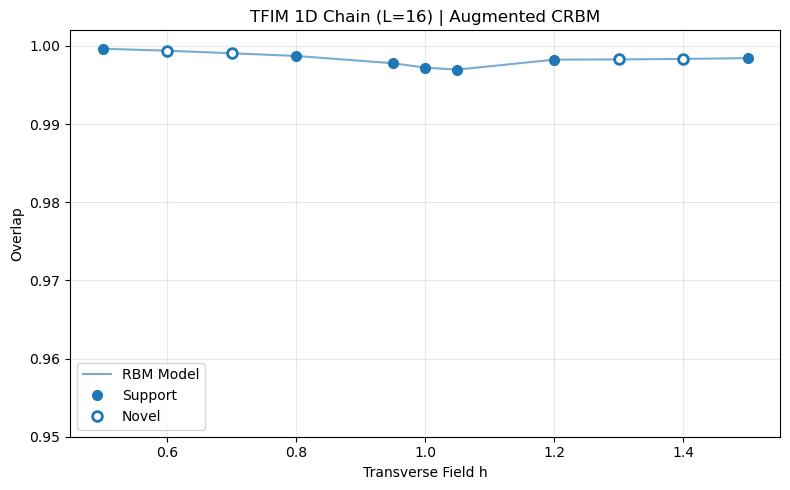

In [5]:
print("Generating full Hilbert space for exact evaluation...")
all_states = generate_all_states(SYSTEM_SIZE, device)
all_eval_h = sorted(list(set(h_support + h_novel)))

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 35)

for h_val in all_eval_h:
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    if not gt_path.exists():
        continue

    overlap = compute_overlap(model, h_val, gt_path, all_states)
    is_supp = any(np.isclose(h_val, s, atol=1e-5) for s in h_support)
    pt_type = "Support" if is_supp else "Novel"

    results.append({"h": h_val, "overlap": overlap, "type": pt_type})
    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5), dpi=100)
supp = df_res[df_res["type"] == "Support"]
nov  = df_res[df_res["type"] == "Novel"]
plt.plot(df_res["h"], df_res["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")
plt.xlabel("Transverse Field h")
plt.ylabel("Overlap")
plt.title(f"TFIM 1D Chain (L={SYSTEM_SIZE}) | Augmented CRBM")
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"crbm_tfim_16_{TRAIN_SAMPLES}_entropy_{timestamp}.pt"
save_path = models_dir / filename

config = {
    "train_samples": TRAIN_SAMPLES,
    "epochs": N_EPOCHS,
    "h_support": h_support,
    "h_novel": h_novel,
    "lr_init": LR_INIT
}

save_model(model, optimizer, config, results, save_path)

Model saved to: models/crbm_tfim_16_20000_entropy_20260113_212827.pt
